In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import multiprocessing as mp
from functools import partial, cmp_to_key
from numba import jit
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [2]:
wc_teams = [ 
"Russia",
"Brazil",
"Iran",
"Japan",
"Mexico",
"Belgium",
"South Korea",
"Saudi Arabia",
"Germany",
"England",
"Spain",
"Nigeria",
"Costa Rica",
"Poland",
"Egypt",
"Iceland",
"Serbia",
"Portugal",
"France",
"Uruguay",
"Argentina",
"Colombia",
"Panama",
"Senegal",
"Morocco",
"Tunisia",
"Switzerland",
"Croatia",
"Sweden",
"Denmark",
"Australia",
"Peru",
]

group_a = ['Russia','Saudi Arabia','Egypt','Uruguay']
group_b = ['Portugal','Spain','Morocco','Iran']
group_c = ['France','Australia','Peru','Denmark']
group_d = ['Argentina','Iceland','Croatia','Nigeria']
group_e = ['Brazil','Switzerland','Costa Rica','Serbia']
group_f = ['Germany','Mexico','Sweden','South Korea']
group_g = ['Belgium','Panama','Tunisia','England']
group_h = ['Poland','Senegal','Colombia','Japan']
teams = pd.read_csv('teams_with_points.csv')
wc_teams = teams[teams.team.isin(wc_teams)]
group_a = teams[teams.team.isin(group_a)]
group_b = teams[teams.team.isin(group_b)]
group_c = teams[teams.team.isin(group_c)]
group_d = teams[teams.team.isin(group_d)]
group_e = teams[teams.team.isin(group_e)]
group_f = teams[teams.team.isin(group_f)]
group_g = teams[teams.team.isin(group_g)]
group_h = teams[teams.team.isin(group_h)]

groups = [group_a,group_b,group_c,group_d,group_e,group_f,group_g,group_h]

In [31]:
with open('wc_model.pkl', 'rb') as file:
    model_file = pickle.load(file)
    trace = model_file['trace']

atts = trace['chance_creation']
defs = trace['chance_supression']
chance_quality = trace['chance_quality']
defense_quality = trace['defense_quality']
shots_inter = trace['shots_intercept']
goals_inter = trace['goals_intercept']
home_inter = trace['home']

trace_args = (atts, defs, chance_quality, defense_quality, shots_inter, goals_inter, home_inter)

In [4]:
@jit(nopython=True)
def simulate_wc_match(trace_args, teams, home=(False,False)):
    atts, defs, chance_quality, defense_quality, shots_inter, goals_inter, home_inter = trace_args
    num_samples = len(home_inter)
    idx = np.random.randint(0,num_samples)
    atts_0 = atts[idx, teams[0]]
    atts_1 = atts[idx, teams[1]]
    defs_0 = defs[idx, teams[0]]
    defs_1 = defs[idx, teams[1]]
    chance_quality_0 = chance_quality[idx, teams[0]]
    chance_quality_1 = chance_quality[idx, teams[1]]
    defense_quality_0 = defense_quality[idx, teams[0]]
    defense_quality_1 = defense_quality[idx, teams[1]]
    shots_inter = shots_inter[idx]
    goals_inter = goals_inter[idx]
    home_inter = home_inter[idx]

    home_shots_theta = shots_inter + atts_0 + defs_1
    if home[0]:
        home_shots_theta += home_inter
    away_shots_theta = shots_inter + atts_1 + defs_0
    if home[1]:
        away_shots_theta += home_inter
    home_goals_theta = np.exp(goals_inter + home_shots_theta + chance_quality_0 + defense_quality_1)
    away_goals_theta = np.exp(goals_inter + away_shots_theta + chance_quality_1 + defense_quality_0)
    home_goals = np.random.poisson(home_goals_theta)
    away_goals = np.random.poisson(away_goals_theta)
    
    return home_goals, away_goals

In [5]:
def simulate_group_matches(group, trace_args):
    indices = group.i.values
    pts = np.zeros(len(indices))
    matches = {}
    for i in range(len(indices)):
        home_i = indices[i]
        home_team = group[group.i == home_i].team.values[0]
        for j in range(i+1,len(indices)):
            away_i = indices[j]
            away_team = group[group.i == away_i].team.values[0]
            if (home_team == 'Russia'):
                home = (True,False)
            elif (away_team == 'Russia'):
                home = (False,True)
            else:
                home = (False,False)
            home_goals, away_goals = simulate_wc_match(trace_args, [home_i,away_i], home)
            matches[(home_team, away_team)] = home_goals, away_goals
    return matches

def get_group_ranking(group, group_matches):
    group_stats = {}
    for team in group.team.values:
        group_stats[team] = [0,0,0]
    for (home, away),(home_g, away_g) in group_matches.items():
        group_stats[home][1] += home_g
        group_stats[home][2] += away_g
        group_stats[away][1] += away_g
        group_stats[away][2] += home_g
        if home_g > away_g:
            group_stats[home][0] += 3
        elif home_g < away_g:
            group_stats[away][0] += 3
        else:
            group_stats[home][0] += 1
            group_stats[away][0] += 1
            
    def cmp_teams(team_a, team_b):
        a = team_a[1]
        b = team_b[1]
        if a[0] > b[0]:
            return -1
        elif a[0] < b[0]:
            return 1
        else:
            a_diff = a[1] - a[2]
            b_diff = b[1] - b[2]
            if a_diff > b_diff:
                return -1
            elif a_diff < b_diff:
                return 1
            else:
                if a[2] > b[2]:
                    return -1
                elif a[2] < b[2]:
                    return 1
                else:
                    return 0
    return sorted(group_stats.items(), key=cmp_to_key(cmp_teams))

def simulate_groups(groups, trace_args):
    group_tables = []
    for group in groups:
        group_matches = simulate_group_matches(group, trace_args)
        group_tables.append(get_group_ranking(group, group_matches))
    
    return group_tables

def get_round_16_matches(group_tables):
    matches = []
    for i in range(0,len(group_tables),2):
        match = group_tables[i][0][0], group_tables[i+1][1][0]
        matches.append(match)
    for i in range(0,len(group_tables),2):
        match = group_tables[i][1][0], group_tables[i+1][0][0]
        matches.append(match)
    return matches

def get_ko_matches(teams):
    matches = []
    for i in range(0,len(teams),2):
        match = teams[i], teams[i+1]
        matches.append(match)
    return matches

def simulate_ko(matches, wc_teams, trace_args):
    round_16_winners = []
    for match in matches:
        team_0 = wc_teams[wc_teams.team == match[0]].i.values[0]
        team_1 = wc_teams[wc_teams.team == match[1]].i.values[0]
        home = (match[0] == 'Russia', match[1] == 'Russia')
        while True:
            goals_0, goals_1 = simulate_wc_match(trace_args, (team_0,team_1), home)
            if goals_0 > goals_1:
                round_16_winners.append(match[0])
                break
            elif goals_0 < goals_1:
                round_16_winners.append(match[1])
                break
            else:
                continue
    return round_16_winners

def simulate_wc(groups, wc_teams, trace_args):
    group_tables = simulate_groups(groups, trace_args)
    round_16_matches = get_round_16_matches(group_tables)
    quater_finals = simulate_ko(round_16_matches, wc_teams, trace_args)
    semi_finals = simulate_ko(get_ko_matches(quater_finals), wc_teams, trace_args)
    final = simulate_ko(get_ko_matches(semi_finals), wc_teams, trace_args)
    wc_winner = simulate_ko([final], wc_teams, trace_args)
    return [team for match in round_16_matches for team in match], quater_finals, semi_finals, final, wc_winner

def wc_stats(groups, wc_teams, trace_args, n_sims=10):
    columns = ['round_16','quater_finals', 'semi_finals', 'final', 'winner']
    df = pd.DataFrame(data=np.zeros((len(wc_teams),len(columns)), dtype=np.long), columns=columns, index=wc_teams.i.values)
    wc_df = wc_teams.join(df)
    name_to_index = dict(zip(wc_df.team.values,wc_df.team.index.values))
    for n in range(n_sims):
        sim_res = simulate_wc(groups, wc_teams, trace_args)
        round_16, quater_finals, semi_finals, final, wc_winner = sim_res
        round_16_i = [name_to_index[t] for t in round_16]
        wc_df.loc[round_16_i, 'round_16'] += 1
        quater_i = [name_to_index[t] for t in quater_finals]
        wc_df.loc[quater_i, 'quater_finals'] += 1
        semi_i = [name_to_index[t] for t in semi_finals]
        wc_df.loc[semi_i, 'semi_finals'] += 1
        final_i = [name_to_index[t] for t in final]
        wc_df.loc[final_i, 'final'] += 1
        winner_i = [name_to_index[t] for t in wc_winner]
        wc_df.loc[winner_i, 'winner'] += 1
    return wc_df

In [32]:
n_sims = 1000
sort_cols = ['winner', 'final', 'semi_finals', 'quater_finals', 'round_16']
wc_data = wc_stats(groups, wc_teams, trace_args, n_sims=n_sims).sort_values(sort_cols, ascending=False)
wc_data

,team,i,fifa_points,round_16,quater_finals,semi_finals,final,winner
70,Germany,70,1544.0,964,742,594,453,319
3,Belgium,3,1346.0,910,751,426,292,155
64,Brazil,64,1384.0,896,607,399,262,143
75,Portugal,75,1306.0,843,734,510,245,138
34,Spain,34,1162.0,813,655,411,179,61
65,Argentina,65,1254.0,806,471,235,97,41
63,Switzerland,63,1179.0,722,299,138,78,36
83,France,83,1166.0,734,469,235,88,29
99,Poland,99,1128.0,765,342,103,46,15
126,Uruguay,126,976.0,905,351,165,35,14


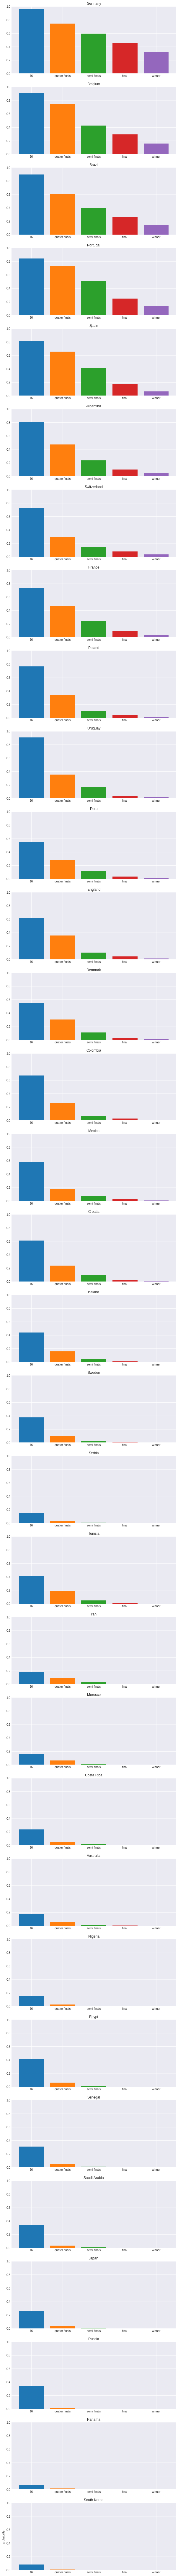

In [34]:
labels = ['16', 'quater finals', 'semi finals', 'final', 'winner']
fig, axarr = plt.subplots(len(wc_data), figsize=(10, len(wc_data)*5))
for ax, team in zip(axarr, wc_data.team.values):
    team_data = wc_data[wc_data.team == team]
    ax.bar(np.arange(5), team_data.values[0][-5:] / n_sims, tick_label=labels, color=plt.cm.tab10(np.arange(5)))
    plt.ylabel('probability')
    ax.set_ylim(0,1)
    ax.set_title(team)